### Visualización de datos litológicos con la libreria matplotlib

Añadir información litológica a un gráfico de curva de pozo puede mejorar la interpretación petrofísica o geológica. Permite comprender por qué algunas respuestas de registro se comportan de cierta manera. Estos datos pueden provenir de una interpretación mineralógica previa o de muestreo durante la perforación 'mudloging'.
Este codigo en jupyter tiene como proposito determinar partiendo de la carga masiva de un conjunto de datos indicarle el nombre del pozo para poder ser ubicado y así poder visualizar su litología según la información capturada y guardada en formato .csv.
El primer paso es incorporar las librerias con las que trabajaremos en este artículo. Usaremos pandas, numpy y matplotlib con sus variantes en este caso una lista de colores y la funcionalidad patch. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

Debido a que se trata de un conjunto de datos bastante grande, es posible que puedan ocurrir excepciones durante la lectura de los datos utilizaremos try ... except. Esto permite que el programa continúe ejecutándose sin detenerse abruptamente cuando se encuentra con un error. usaremos entonces la lectura por pozo y también tomaremos solo las curvas (columnas) que necesitemos. Podemos hacerlo tomando un subconjunto de los datos como se muestra a continuación.

In [2]:
# Cargar los datos (nos aseguramos que la ruta sea correcta para el entorno)
try:
    alldata = pd.read_csv(r'C:\Users\Usuario\Archivos_LAS\xeek_train_subset.csv')
    data = alldata.loc[alldata['WELL'] == '15_9_13'][['DEPTH_MD', 'GR', 'RHOB', 'NPHI', 'FORCE_2020_LITHOFACIES_LITHOLOGY']].copy()
    data.rename(columns={'FORCE_2020_LITHOFACIES_LITHOLOGY':'LITHOLOGY'}, inplace=True)
except FileNotFoundError:
    print("WARNING: 'xeek_train_subset.csv' not found. Using dummy data for demonstration.")
    depth = np.linspace(1600, 3000, 100) # Ajustamos dummy data al rango de interés
    data = pd.DataFrame({
        'DEPTH_MD': depth,
        'GR': np.sin(depth/50) * 50 + 100 + np.random.normal(0, 5, len(depth)),
        'RHOB': np.sin(depth/70) * 0.1 + 2.5 + np.random.normal(0, 0.01, len(depth)),
        'NPHI': np.cos(depth/60) * 0.05 + 0.2 + np.random.normal(0, 0.005, len(depth)),
        'LITHOLOGY': np.random.choice([30000, 65030, 65000, 70000, 80000], size=len(depth))
    })
    data['GR'] = np.clip(data['GR'], 20, 200) # Nos aseguramos que GR tenga un rango razonable


### Configuración de las litologías mediante un diccionario anidado
Las litologías que aparecen actualmente en la columna de litología contienen una serie de números. Podemos asignarlos a un diccionario anidado donde tenemos el nombre completo de la litología, un número simplificado (si se requiere para la conversión), el patrón litológico y el color correspondiente.

Los colores se basan en el sitio web del Servicio Geológico de Kansas. Sin embargo, los símbolos de tramado son limitados en la configuración predeterminada de matplotlib. Para esto se agrega al diccionario la columna hatch que permite definir al menos mediante simbolos los patrones que mejor se ajustan a las litologías.

In [3]:
# Define el diccionario lithology_numbers como en tu notebook
lithology_numbers = {30000: {'lith':'Sandstone', 'lith_num':1, 'hatch': '..', 'color':'#ffff00'},
                     65030: {'lith':'Sandstone/Shale', 'lith_num':2, 'hatch':'-.', 'color':'#ffe119'},
                     65000: {'lith':'Shale', 'lith_num':3, 'hatch':'--', 'color':'#bebebe'},
                     80000: {'lith':'Marl', 'lith_num':4, 'hatch':'', 'color':'#7cfc00'},
                     74000: {'lith':'Dolomite', 'lith_num':5, 'hatch':'-/', 'color':'#8080ff'},
                     70000: {'lith':'Limestone', 'lith_num':6, 'hatch':'-|-', 'color':'#80ffff'},
                     70032: {'lith':'Chalk', 'lith_num':7, 'hatch':'..', 'color':'#80ffff'},
                     88000: {'lith':'Halite', 'lith_num':8, 'hatch':'x', 'color':'#7ddfbe'},
                     86000: {'lith':'Anhydrite', 'lith_num':9, 'hatch':'', 'color':'#ff80ff'},
                     99000: {'lith':'Tuff', 'lith_num':10, 'hatch':'||', 'color':'#ff8c00'},
                     90000: {'lith':'Coal', 'lith_num':11, 'hatch':'', 'color':'black'},
                     93000: {'lith':'Basement', 'lith_num':12, 'hatch':'-|', 'color':'#ef138a'}}

El siguiente bloque de código permite visualizar las litologias con sus patrones correspondientes

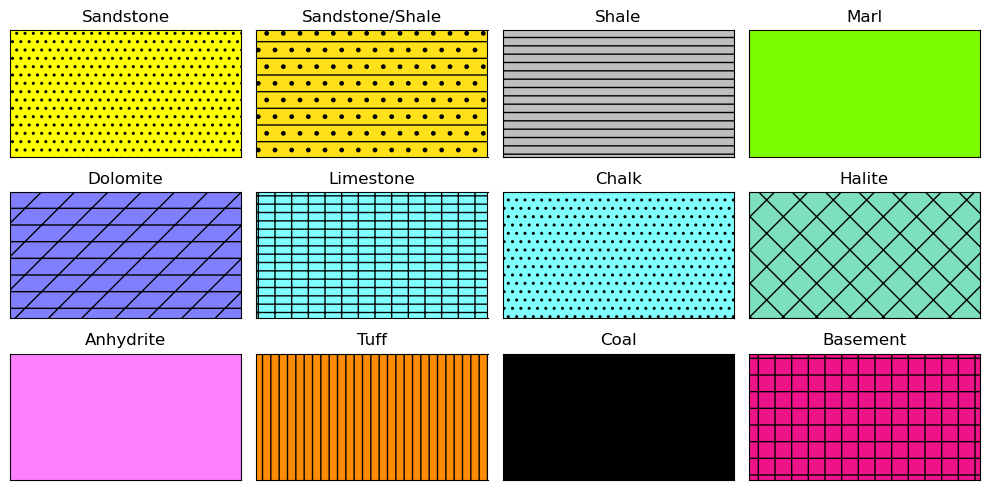

In [4]:
y = [0, 1]
x = [1, 1]

fig, axes = plt.subplots(ncols=4,nrows=3, sharex=True, sharey=True,
                         figsize=(10,5), subplot_kw={'xticks': [], 'yticks': []})

for ax, key in zip(axes.flat, lithology_numbers.keys()):
    ax.plot(x, y)
    ax.fill_betweenx(y, 0, 1, facecolor=lithology_numbers[key]['color'], hatch=lithology_numbers[key]['hatch'])
    ax.set_xlim(0, 0.1)
    ax.set_ylim(0, 1)
    ax.set_title(str(lithology_numbers[key]['lith']))

plt.tight_layout()
plt.show()

### Configuración del gráfico de la curva de GR con litología
Esto nos permite reutilizar fácilmente el código para otros datos tabulados (DataFrame), siempre que los nombres de las curvas sean los mismos. Este nueva bloque acepta tres argumentos: los datos tabulados, la profundidad superior y la profundidad inferior. Por su puesto el argumento **'None'** implica poder colocar esta información en la ultima línea de código (In[6] en este caso) . Este código generará un gráfico de registro de pozo con un eje (tracks) que contiene la curva de Rayos Gamma con  datos de litología.

In [5]:
def grafico_lito(logs, lithology_map_data, depth_min=None, depth_max=None):
    logs = logs.sort_values(by='DEPTH_MD').reset_index(drop=True)

    # Filtrar los datos por el rango de profundidad si se especifica
    if depth_min is not None and depth_max is not None:
        logs = logs[(logs['DEPTH_MD'] >= depth_min) & (logs['DEPTH_MD'] <= depth_max)].copy()
        logs.reset_index(drop=True, inplace=True)

    if logs.empty:
        print("No hay datos en el rango de profundidad especificado.")
        return

    # Crear figura y solo 1 eje (track)
    fig, ax = plt.subplots(figsize=(6, 12))

    # Invertir eje Y
    ax.invert_yaxis()
    ax.set_ylabel('Depth (MD)')
    ax.set_xlabel('Litología')
    ax.set_xticks([])
    ax.set_title('Lithology (GR Bounded)')

    # Configurar los límites del eje Y
    ax.set_ylim(depth_max, depth_min)
    
    
    # Rango del eje X
    litho_track_x_min = np.min(logs['GR'])
    if litho_track_x_min > 0:
        litho_track_x_min = 0 
    else:
        litho_track_x_min = np.min(logs['GR']) - 5 

    litho_track_x_max = np.max(logs['GR']) + 50
    if litho_track_x_max < 150:
        litho_track_x_max = 150

    ax.set_xlim(litho_track_x_min, litho_track_x_max)

    # Datos de litología
    lith_values = logs['LITHOLOGY'].values
    depth_values = logs['DEPTH_MD'].values
    change_points = np.where(lith_values[:-1] != lith_values[1:])[0]
    start_indices = np.concatenate(([0], change_points + 1))
    end_indices = np.concatenate((change_points, [len(lith_values) - 1]))

    for i in range(len(start_indices)):
        start_idx = start_indices[i]
        end_idx = end_indices[i]
        current_lithology_code = lith_values[start_idx]

        color = lithology_map_data.get(current_lithology_code, {}).get('color', '#CCCCCC')
        hatch = lithology_map_data.get(current_lithology_code, {}).get('hatch', None)

        segment_depths = depth_values[start_idx : end_idx + 1]
        segment_gr_values = logs['GR'].iloc[start_idx : end_idx + 1].values

        ax.fill_betweenx(
            segment_depths,
            segment_gr_values,
            litho_track_x_max,
            facecolor=color,
            edgecolor='none',
            linewidth=0,
            zorder=1
        )

        if hatch:
            ax.fill_betweenx(
                segment_depths,
                segment_gr_values,
                litho_track_x_max,
                facecolor='none',
                edgecolor='black',
                hatch=hatch,
                linewidth=0.5,
                alpha=0.7,
                zorder=2
            )

    # Superponer curva GR
    ax.plot(logs['GR'], logs['DEPTH_MD'], color='green', linewidth=1.5, label='GR', zorder=5)
    ax.grid(True)

    # Leyenda
    legend_elements = []
    unique_lithologies_present = logs['LITHOLOGY'].unique()
    sorted_lith_codes = sorted(unique_lithologies_present, key=lambda k: lithology_map_data.get(k, {}).get('lith_num', 999))

    for lith_code in sorted_lith_codes:
        if lith_code in lithology_map_data:
            lith_name = lithology_map_data[lith_code]['lith']
            color = lithology_map_data[lith_code]['color']
            hatch = lithology_map_data[lith_code]['hatch']
            legend_elements.append(Patch(facecolor=color, hatch=hatch, label=lith_name))
            
    # Escala fija para rayos gamma (0–150 API)
    ax.set_xlim(0, 150)
    ax.set_xticks(np.arange(0, 151, 25))  # ticks cada 25 unidades
    ax.set_xlabel('Gamma Ray (API)')

    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.tight_layout()
    plt.show()

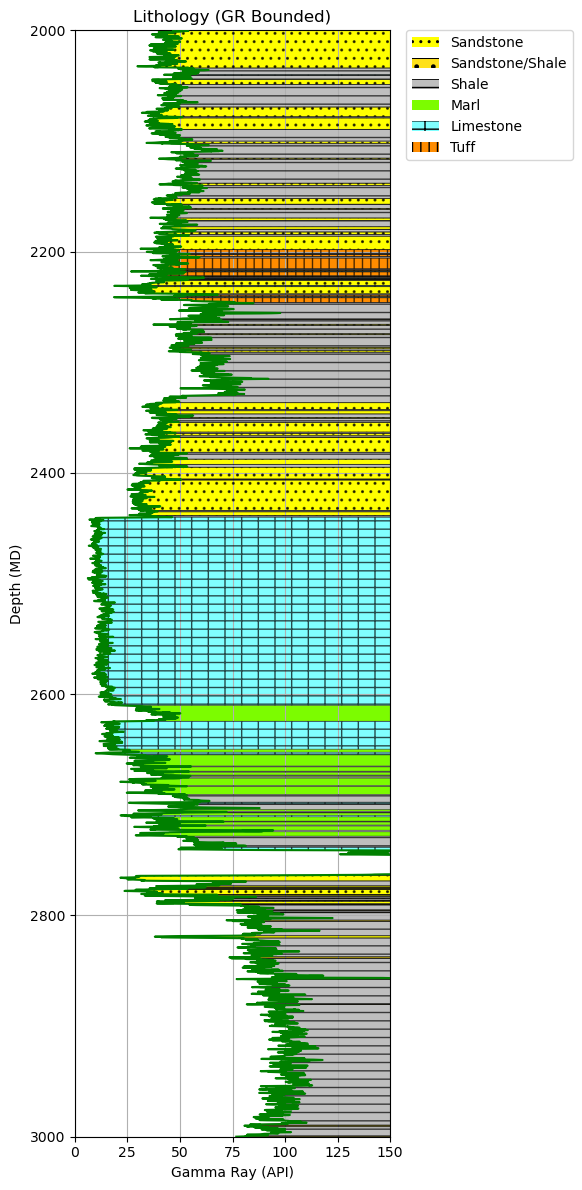

In [6]:
# --- Llamada a la función con el rango de profundidad deseado ---
grafico_lito(data, lithology_numbers, depth_min=2000, depth_max=3000)